## Part 0: Packages

In [1]:
import numpy as np 
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import igraph
import scvelo as scv
import loompy as lmp
import anndata
from scipy import io
from scipy.io import mmread
from scipy.sparse import csr_matrix, coo_matrix
import scanorama
import os

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.13


## Part 1: QC and Samples Preparation

### Louie et. al Samples Upload

In [3]:
louie = sc.read_h5ad("Louie.h5ad")

### Good et. al samples upload

In [4]:
good = sc.read_h5ad("Good.h5ad")

### Haradhvala et. al samples upload

In [3]:
haradhvala = sc.read_h5ad("Haradhvala.h5ad")

## Part 2: merge Anndata

In [7]:
merged_list = [good, louie, haradhvala] 

In [9]:
merged_adata = sc.concat(merged_list)

In [10]:
merged_adata.obs.head()

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample
AAACCTGAGACTTGAA-1,812,812,3062.0,47.0,1.534945,GSE168940_pt276-day7-car-t-filtered_feature_bc...
AAACCTGAGCCACTAT-1,1252,1252,3165.0,139.0,4.391785,GSE168940_pt276-day7-car-t-filtered_feature_bc...
AAACCTGAGCTCAACT-1,2453,2453,7627.0,226.0,2.963157,GSE168940_pt276-day7-car-t-filtered_feature_bc...
AAACCTGAGGGCTCTC-1,2869,2869,8951.0,199.0,2.223215,GSE168940_pt276-day7-car-t-filtered_feature_bc...
AAACCTGAGGTAAACT-1,3873,3873,15185.0,543.0,3.575897,GSE168940_pt276-day7-car-t-filtered_feature_bc...


In [12]:
merged_adata.var_names_make_unique()

In [13]:
sc.pp.filter_cells(merged_adata, min_genes= 200)
sc.pp.filter_genes(merged_adata, min_cells= 3)

filtered out 41 cells that have less than 200 genes expressed


In [14]:
merged_adata.obs.shape

(35936, 6)

In [15]:
merged_adata.var["mt"] = merged_adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(merged_adata, qc_vars= ["mt"], percent_top= None, log1p= False, inplace= True)

In [16]:
merged_adata.obs.head(2)

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample
AAACCTGAGACTTGAA-1,731,731,2792.0,47.0,1.683381,GSE168940_pt276-day7-car-t-filtered_feature_bc...
AAACCTGAGCCACTAT-1,1148,1148,2925.0,139.0,4.752137,GSE168940_pt276-day7-car-t-filtered_feature_bc...


In [17]:
merged_adata = merged_adata[merged_adata.obs.n_genes_by_counts < 5000, :]
merged_adata = merged_adata[merged_adata.obs.total_counts < 20000, :]
merged_adata = merged_adata[merged_adata.obs.pct_counts_mt < 10, :]

In [18]:
merged_adata.obs.shape

(34564, 6)

normalizing counts per cell
    finished (0:00:00)


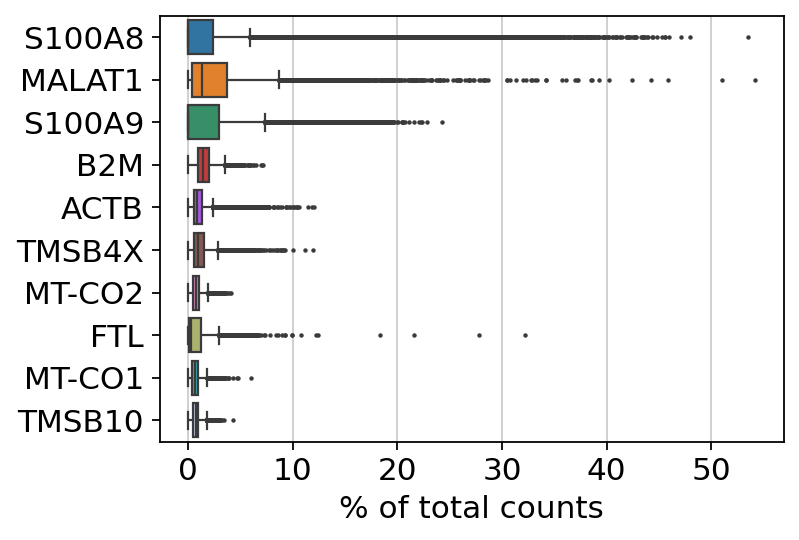

In [19]:
sc.pl.highest_expr_genes(merged_adata,n_top= 10)

In [20]:
sc.pp.normalize_total(merged_adata, target_sum= 1e4)
sc.pp.log1p(merged_adata)
sc.pp.highly_variable_genes(merged_adata,min_mean= 0.0125, max_mean= 3, min_disp= 0.5)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


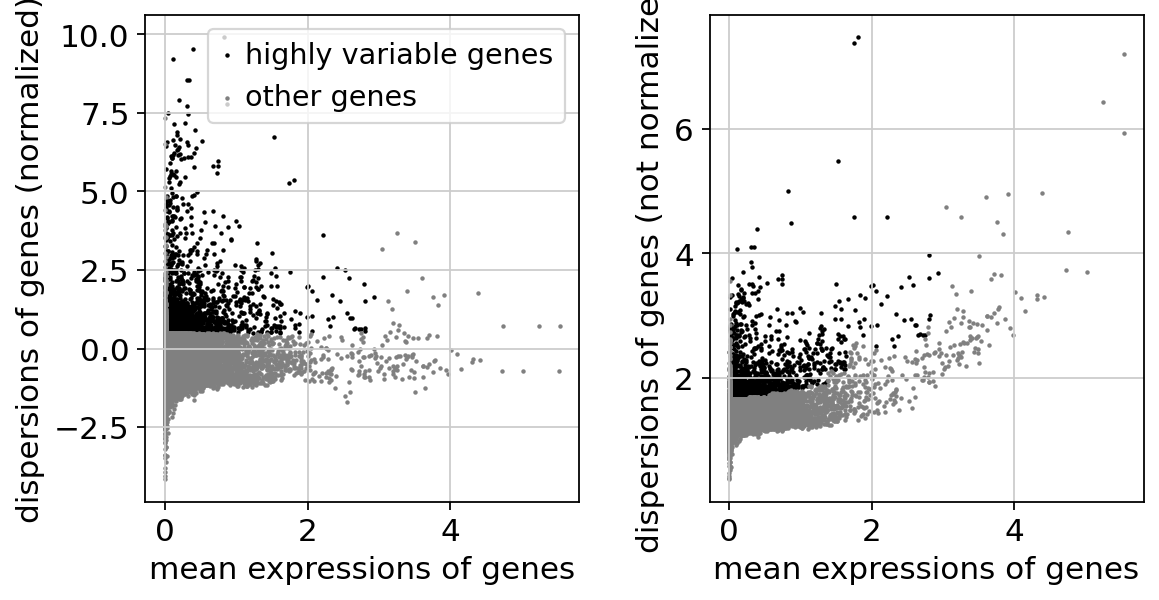

In [21]:
sc.pl.highly_variable_genes(merged_adata)

In [22]:
merged_adata.raw = merged_adata
merged_adata.var.shape

(11993, 10)

In [23]:
merged_adata = merged_adata[:, merged_adata.var.highly_variable]
merged_adata.var.shape

(2328, 10)

In [24]:
sc.pp.regress_out(merged_adata,["total_counts","pct_counts_mt"])
sc.pp.scale(merged_adata, max_value= 10)
sc.tl.pca(merged_adata, svd_solver= "arpack")

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:47)
computing PCA
    with n_comps=50
    finished (0:00:13)


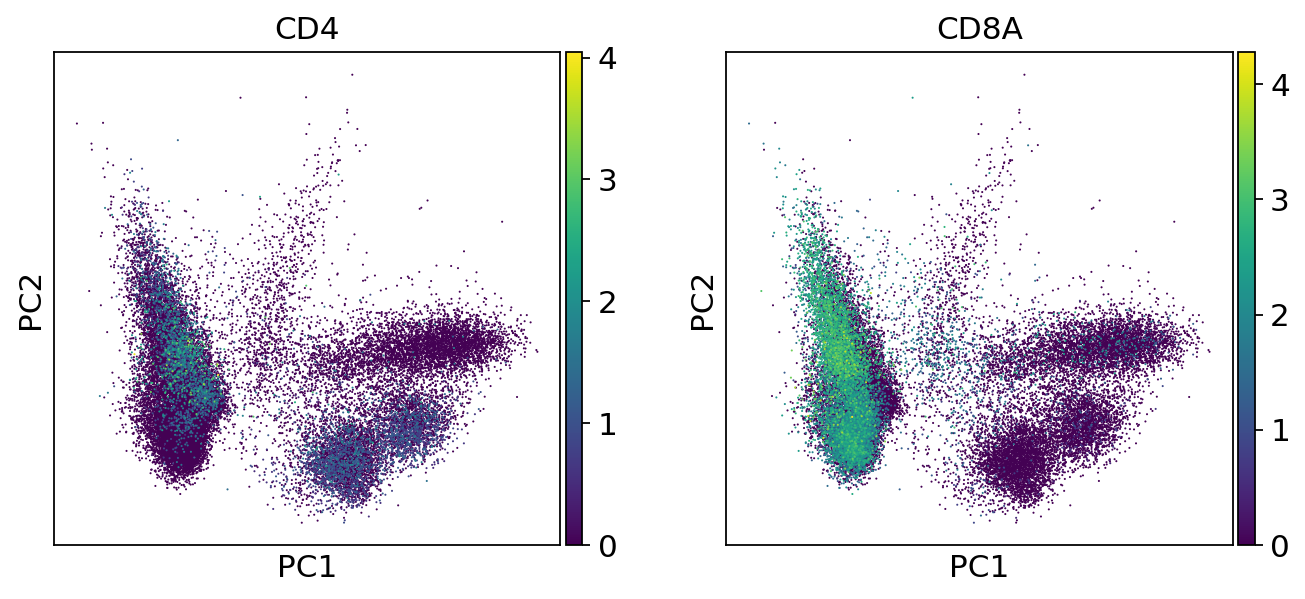

In [25]:
sc.pl.pca(merged_adata,color = ["CD4", "CD8A"])

In [26]:
sc.pp.neighbors(merged_adata)
sc.tl.umap(merged_adata)
sc.tl.leiden(merged_adata, resolution=0.2)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:30)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:11)


In [27]:
merged_adata.var.index[merged_adata.var.index.str.contains("CD", case=False, regex=True)]

Index(['CDCA8', 'CDC20', 'CDC14A', 'CD101', 'CD84', 'CD244', 'CD55',
       'CDC42EP3', 'CD8A', 'CD8B', 'CCDC141', 'CD28', 'PRKCD', 'CD96',
       'CD200R1', 'CCDC191', 'HACD2', 'CCDC14', 'CCDC125', 'PTCD2', 'CD74',
       'CDKN1A', 'CD109', 'CDK19', 'CDK6', 'CDHR3', 'CCDC136', 'SMARCD3',
       'CDC14B', 'CDK5RAP2', 'CDK1', 'CDH23', 'DPCD', 'CD151', 'CDKN1C',
       'CD59', 'CCDC88B', 'C2CD3', 'CD9', 'CD27', 'CD4', 'CD69', 'C2CD5',
       'ABCD2', 'CDK17', 'CDK2AP1', 'CCDC92', 'CDKL1', 'CDKN3', 'CCDC88C',
       'CDAN1', 'BRICD5', 'CD68', 'CD7', 'CD226', 'CDC34', 'CD70', 'CDKN2D',
       'GUCD1', 'CCDC157'],
      dtype='object')

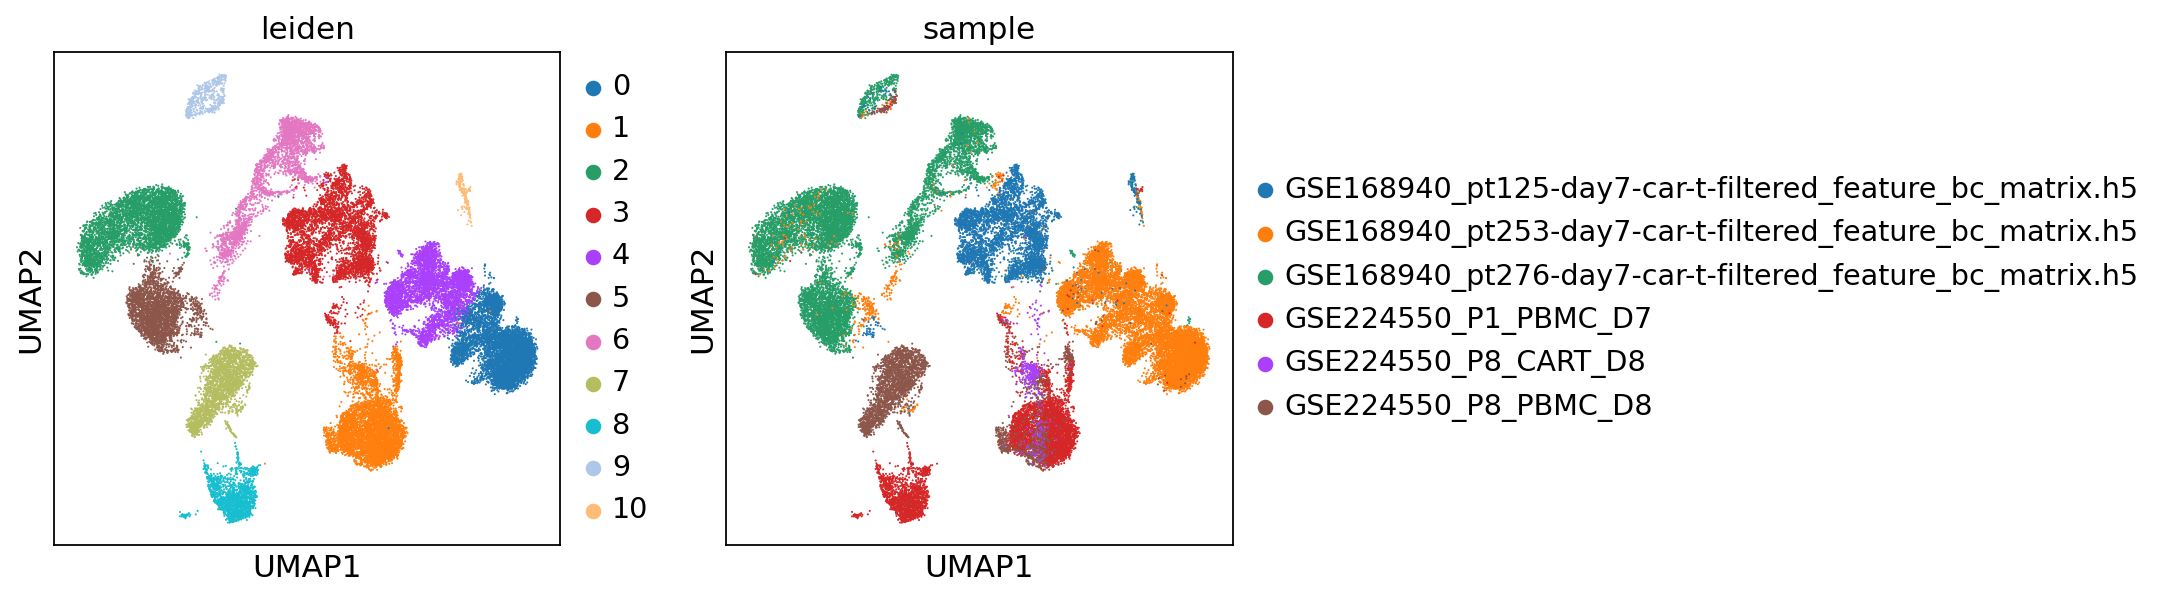

In [28]:
sc.pl.umap(merged_adata,color= "leiden", save="Scanorama_unintegrated_D7_leiden.pdf")
sc.pl.umap(merged_adata,color= "sample", save="Scanorama_unintegrated_D7_sample.pdf")

In [29]:
merged_adata

AnnData object with n_obs × n_vars = 34564 × 2328
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
merged_adata.write("Scanorama_unintegrated.h5ad")

In [12]:
!pwd

/home/mohammed/D7_python_folder


## Part 3: Integration

In [13]:
#merged_adata = sc.read_h5ad("Scanorama_unintegrated.h5ad")

In [3]:
merged_adata_ = merged_adata.raw.to_adata() 

In [4]:
merged_adata_.uns['log1p']['base']=None

In [5]:
sc.pp.highly_variable_genes(merged_adata_ , min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'leiden')
print("Highly variable genes intersection: %d"%sum(merged_adata_.var.highly_variable_intersection))
print("Number of batches where gene is variable:")
print(merged_adata_.var.highly_variable_nbatches.value_counts())
var_genes_batch = merged_adata_.var.highly_variable_nbatches > 0

Highly variable genes intersection: 0
Number of batches where gene is variable:
highly_variable_nbatches
1     2270
2     1925
0     1578
3     1400
4     1003
5      740
6      540
7      381
8      287
9      251
10     139
11      74
12      49
13      29
Name: count, dtype: int64


In [6]:
var_select_merged = merged_adata_.var.highly_variable_nbatches > 2
var_genes_merged = var_select_merged.index[var_select_merged]

In [7]:
len(var_genes_merged)

4893

In [8]:
#split per batch into new objects.
batches = merged_adata.obs['sample'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = merged_adata_[merged_adata_.obs['sample'] == batch,]
len(alldata)

12

In [9]:
import scanorama

#subset the individual dataset to the variable genes we defined at the beginning
alldata2 = dict()
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:,var_genes_merged]

#convert to list of AnnData objects
adatas = list(alldata2.values())

GSE168940_pt110-day7-car-t-filtered_feature_bc_matrix.h5
GSE168940_pt116-day7-car-t-filtered_feature_bc_matrix.h5
GSE168940_pt125-day7-car-t-filtered_feature_bc_matrix.h5
GSE168940_pt129-day7-car-t-filtered_feature_bc_matrix.h5
GSE168940_pt245-day7-car-t-filtered_feature_bc_matrix.h5
GSE168940_pt253-day7-car-t-filtered_feature_bc_matrix.h5
GSE168940_pt263-day7-car-t-filtered_feature_bc_matrix.h5
GSE168940_pt276-day7-car-t-filtered_feature_bc_matrix.h5
GSE168940_pt282-day7-car-t-filtered_feature_bc_matrix.h5
GSE224550_P1_PBMC_D7
GSE224550_P8_CART_D8
GSE224550_P8_PBMC_D8


In [10]:
# run scanorama.integrate
scanorama.integrate_scanpy(adatas, dimred = 20)

Found 4893 genes among all datasets
[[0.00000000e+00 4.47190350e-01 7.63847732e-01 1.77242888e-01
  3.50940666e-02 1.23010130e-02 2.89096916e-02 4.82392668e-04
  2.41196334e-04 9.96015936e-04 1.17647059e-02 1.33288904e-03]
 [0.00000000e+00 0.00000000e+00 5.88408355e-01 7.81181619e-01
  6.82553692e-02 4.38364225e-02 2.83314978e-01 7.06090026e-02
  1.23565755e-01 7.94351280e-03 1.17647059e-02 1.49950017e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.39824945e-01
  4.06428083e-01 8.25165261e-02 1.90107135e-01 1.13973102e-01
  1.00296330e-01 4.10303168e-03 2.94117647e-02 8.66195578e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.18818381e-01 4.07002188e-01 7.39606127e-01 6.78336980e-02
  1.53172867e-01 1.31291028e-02 2.62582057e-02 2.18818381e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.35914885e-01 5.99669604e-01 3.86747936e-01
  3.78893215e-02 4.64807437e-03 0.00000000e+00 3.59880040e-02]
 [0.00000000e+00 0.00000000e+

/home/mohammed/.venv/lib/python3.12/site-packages/scanorama/scanorama.py:284: ImplicitModificationWarning: Setting element `.obsm['X_scanorama']` of view, initializing view as actual.
  adata.obsm['X_scanorama'] = X_dimred


In [13]:
adatas[0].obsm['X_scanorama'].shape

(8292, 20)

In [16]:
# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas]

# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

# add to the AnnData object, create a new object first
adata_sc = merged_adata.copy()
adata_sc.obsm["Scanorama"] = all_s

(83426, 20)


In [17]:
sc.pp.neighbors(adata_sc, n_pcs =20, use_rep = "Scanorama")
sc.tl.umap(adata_sc)

In [18]:
#fig, axs = plt.subplots(1, 2, figsize=(12,5),constrained_layout=True)
sc.pl.umap(merged_adata_, color="sample", title="Unintegrated D7",
           #ax=axs[0],
           show=False, save= "Unintegrated D7.pdf")
sc.pl.umap(adata_sc, color="sample", title="Integrated D7",
           #ax=axs[1],
           show=False , save= "Integrated D7.pdf")
plt.show()

In [43]:
#sc.pl.umap(adata_sc, color= ["leiden","sample"])
#sc.pl.umap(adata_sc, color= ["CD7", "NKG7"])

In [ ]:
adata_sc.write("Scanorama_Integrated.h5ad")

### Part 4: Conduct Azimuth Cell Annotation for Scanorama `Anndata` object

In [44]:
adata_sc.obs_names_make_unique()
adata_sc.obsm

AxisArrays with keys: X_pca, X_umap, Scanorama

In [19]:
import anndata2ri
from rpy2.robjects import conversion
from rpy2.robjects.conversion import localconverter

with localconverter(anndata2ri.converter):
    %reload_ext rpy2.ipython

In [20]:
%%R
library(reticulate)
library(Seurat)
library(Azimuth)
library(SeuratData)
library(patchwork)
library(SummarizedExperiment)
library(tidyverse)
library(R.utils)
library(scRNAseq)
library(zellkonverter)
library(scater)
library(loomR)
library(Seurat)
library(patchwork)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    ── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%within%() masks IRanges::%within%()
✖ dplyr::collapse()     masks IRanges::collapse()
✖ dplyr::combine()      masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()        masks matrixStats::count()
✖ dplyr::desc()         masks IRanges::desc()
✖ tidyr::expand()       masks S4Vectors::expand()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::first()        masks S4Vectors::first()
✖ dplyr::lag()          masks stats::lag()
✖ 

Loading required package: SeuratObject
Loading required package: sp

Attaching package: ‘SeuratObject’

The following objects are masked from ‘package:base’:

    intersect, t

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Attaching shinyBS
── Installed datasets ──────────────────────────────── SeuratData v0.2.2.9001 ──
✔ pbmcref 1.0.0                         

────────────────────────────────────── Key ─────────────────────────────────────
✔ Dataset loaded successfully
❯ Dataset built with a newer version of Seurat than installed
❓ Unknown version of Seurat installed

Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: 'MatrixGenerics'

The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadD

In [47]:
!mkdir TempDir

In [48]:
adata_sc = adata_sc.raw.to_adata()  #only if adata has RAW saved and thats what you want!!

In [49]:
dirc = "TempDir"

with open(dirc + '/barcodes.tsv', 'w') as f:
    for item in adata_sc.obs_names:
        f.write(item + '\n')

with open(dirc + '/features.tsv', 'w') as f:
    for item in ['\t'.join([x,x,'Gene Expression']) for x in adata_sc.var_names]:
        f.write(item + '\n')

io.mmwrite(dirc + '/matrix.mtx', adata_sc.X.T)

In [50]:
!ls /TempDir/
#barcodes.tsv  features.tsv  matrix.mtx

barcodes.tsv  features.tsv  matrix.mtx


In [51]:
adata_sc.obs.to_csv('TempDir/metadata.csv')

In [52]:
!gzip TempDir/*

In [53]:
!ls TempDir/
#barcodes.tsv.gz  features.tsv.gz  matrix.mtx.gz  metadata.csv.gz

barcodes.tsv.gz  features.tsv.gz  matrix.mtx.gz  metadata.csv.gz


In [54]:
%%R
RawData <- Read10X(data.dir = "TempDir", gene.column = 1)
metaData <- read.csv("TempDir/metadata.csv.gz")
rownames(metaData) <- metaData[["X"]]
metaData[["X"]] <- NULL

adata_sr <- CreateSeuratObject(counts = RawData, meta.data = metaData)

In [55]:
%%R
adata_sr

An object of class Seurat 
11993 features across 34564 samples within 1 assay 
Active assay: RNA (11993 features, 0 variable features)
 1 layer present: counts


### Run Azimuth

In [56]:
%%R
adata_sr_az <- RunAzimuth(adata_sr, reference = "pbmcref")

  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  


detected inputs from HUMAN with id type Gene.name
reference rownames detected HUMAN with id type Gene.name
Normalizing query using reference SCT model
Continuing with remaining 3463 features.
Projecting cell embeddings
Finding query neighbors
Finding neighborhoods
Finding anchors
	Found 3163 anchors
Finding integration vectors
Finding integration vector weights
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Predicting cell labels
Predicting cell labels
Predicting cell labels

Integrating dataset 2 with reference dataset
Finding integration vectors
Integrating data
Computing nearest neighbors
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session
Running UMAP projection
15:43:49 Read 34564 rows
15:43:49 Processing block 1 of 1
15:43:49 Commencing smooth kNN distance calibration using 1 thread w

In [57]:
%%R
adata_sr_az

An object of class Seurat 
12088 features across 34564 samples within 4 assays 
Active assay: RNA (11993 features, 0 variable features)
 1 layer present: counts
 3 other assays present: prediction.score.celltype.l1, prediction.score.celltype.l2, prediction.score.celltype.l3
 2 dimensional reductions calculated: integrated_dr, ref.umap


In [58]:
%%R
write_rds(adata_sr_az, file = "adata_sr_az_Integrated_D7.rds")

### Part 5: Transform back to Scanorama `Anndata` 

In [59]:
%%R
plswork <- readRDS(file = "adata_sr_az_Integrated_D7.rds")
plswork_sce <- as.SingleCellExperiment(plswork)
plswork_sce

class: SingleCellExperiment 
dim: 11993 34564 
metadata(0):
assays(1): counts
rownames(11993): LINC00115 NOC2L ... MAFIP AL592183.1
rowData names(0):
colnames(34564): AAACCTGAGACTTGAA-1 AAACCTGAGCCACTAT-1 ...
  TTTACGTGTCAAAGAT-1 TTTCAGTAGTCTAGAA-1
colData names(19): orig.ident nCount_RNA ... mapping.score ident
reducedDimNames(2): INTEGRATED_DR REF.UMAP
mainExpName: RNA
altExpNames(3): prediction.score.celltype.l1
  prediction.score.celltype.l2 prediction.score.celltype.l3


In addition: Warning messages:
1: Layer 'data' is empty 
2: Layer 'scale.data' is empty 
3: In .check_reddim_names(x, value, withDimnames) :
  non-NULL 'rownames(value)' should be the same as 'colnames(x)' for
'reducedDim<-'. This will be an error in the next release of
Bioconductor.
4: In .check_reddim_names(x, value, withDimnames) :
  non-NULL 'rownames(value)' should be the same as 'colnames(x)' for
'reducedDim<-'. This will be an error in the next release of
Bioconductor.


In [60]:
%%R
writeH5AD(plswork_sce, file = "Scanorama_anndata_azimuth.h5ad")

ℹ Using the 'counts' assay as the X matrix


In [28]:
adata_sc_az = sc.read_h5ad("Scanorama_anndata_azimuth.h5ad")
adata_sc_az.obs_names_make_unique()

In [29]:
adata_sc_az.obsm

AxisArrays with keys: INTEGRATED_DR, REF.UMAP

In [30]:
sc.pp.neighbors(adata_sc_az, n_pcs =30)
sc.tl.umap(adata_sc_az)

In [31]:
adata_sc_az

AnnData object with n_obs × n_vars = 38630 × 13513
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample', 'leiden', 'percent.mt', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'predicted.celltype.l3.score', 'predicted.celltype.l3', 'mapping.score', 'ident'
    uns: 'X_name', 'pca', 'neighbors', 'umap'
    obsm: 'INTEGRATED_DR', 'REF.UMAP', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Part 6: Visualize your Integrated and annotated `Anndata` object

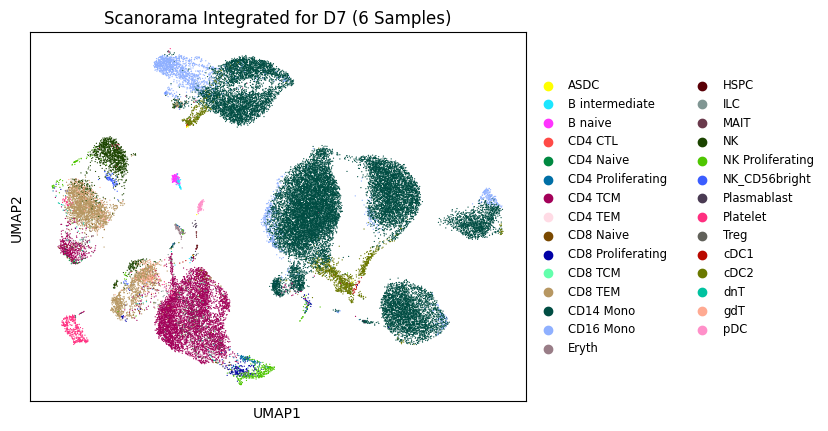

In [34]:
sc.pl.umap(
    adata_sc_az, 
    color="predicted.celltype.l2", 
    legend_loc="right margin",
    legend_fontsize= "small",  # Use a smaller font size
    legend_fontweight='normal',  # Adjust font weight
    legend_fontoutline=1,  # Use a slight outline for better readability
    save="D7_l2.pdf",
    show=True,
    title = "Scanorama Integrated for D7"
)

In [ ]:
sc.pl.umap(
    adata_sc_az, 
    color="predicted.celltype.l1", 
    legend_loc="right margin",
    legend_fontsize= "small",  # Use a smaller font size
    legend_fontweight='normal',  # Adjust font weight
    legend_fontoutline=1,  # Use a slight outline for better readability
    save="D7_l1.pdf",
    show=True,
    title = "Scanorama Integrated for D7"
)